# Phase 3: Manual Labeling

## Objectives
1. Select 50-100 representative days across different conditions
2. Manually label them: Healthy, Cloudy, Curtailment, Soiling, Investigate
3. Build gold standard validation set

In [1]:
import sys
sys.path.insert(0, '/workspaces/O-M-Monte-Carlo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from src.phase3_labeling.labeler import SolarDayLabeler

sns.set_style('darkgrid')
print("Imports successful!")

Imports successful!


## Load Feature Data

In [2]:
# Load engineered features
df_features = pd.read_csv('/workspaces/O-M-Monte-Carlo/data/engineered_features.csv', index_col=0)
print(f"Loaded {len(df_features)} days with features")
print(f"\nFeatures shape: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")
print(f"\nHealthy days: {df_features['healthy'].sum()}, Unhealthy: {(~df_features['healthy']).sum()}")

Loaded 722 days with features

Features shape: (722, 9)
Columns: ['mc_percentile', 'mc_z_score', 'mc_p10', 'mc_p50', 'mc_p90', 'efficiency_ratio', 'ghi_daily', 'yield_daily', 'healthy']

Healthy days: 181, Unhealthy: 541


## Select Representative Days

Strategy: Use k-means clustering on features to find diverse representatives


Selected 76 representative days for labeling
Distribution across clusters:
cluster
0    10
1    10
2    10
3     6
4    10
5    10
6    10
7    10
Name: count, dtype: int64

Healthy ratio in selected: 27.63%


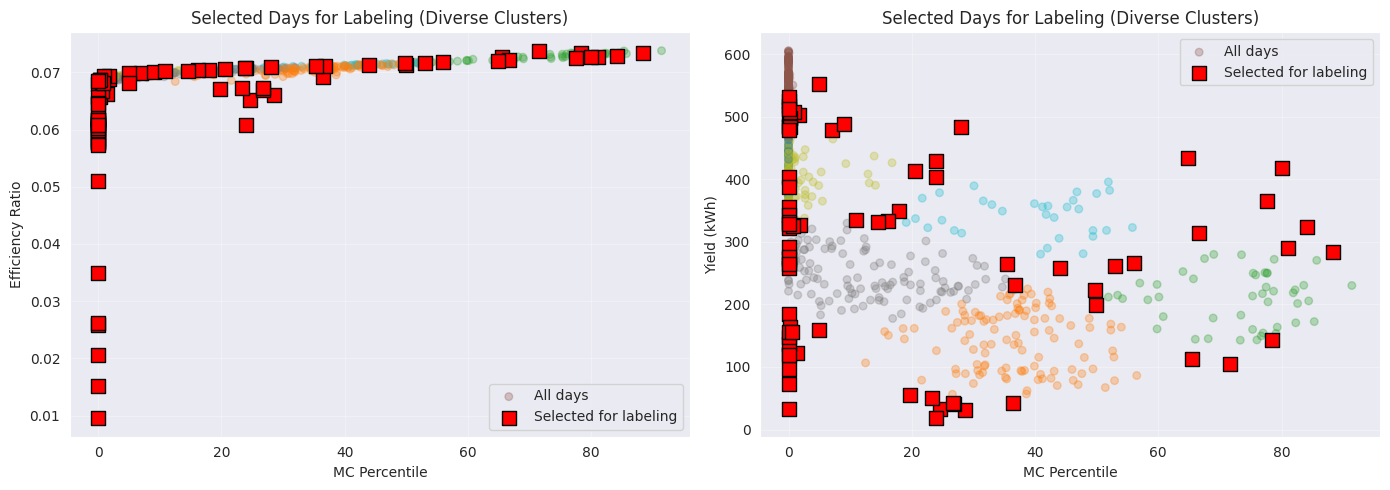


Saved selection visualization to: outputs/phase3_selected_days.png


In [4]:
# Select n_label representative days using k-means clustering
# Goal: diverse sampling across feature space

n_label = 80  # Label 80 days (10-12% of 722)
n_clusters = 8  # 8 clusters * 10 days per cluster = 80 days

# Prepare features for clustering (exclude label column)
feature_cols = [col for col in df_features.columns if col != 'healthy']
X = df_features[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering for diverse selection
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_features['cluster'] = kmeans.fit_predict(X_scaled)

# Select ~10 days from each cluster
selected_indices = []
for cluster_id in range(n_clusters):
    cluster_mask = df_features['cluster'] == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    # Select diversity within cluster: pick max distance from centroid
    if len(cluster_indices) > 0:
        n_select = min(10, len(cluster_indices))
        centroid = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(X_scaled[cluster_indices] - centroid, axis=1)
        top_diverse = cluster_indices[np.argsort(-distances)[:n_select]]
        selected_indices.extend(top_diverse)

selected_indices = sorted(selected_indices)[:n_label]
df_label = df_features.loc[df_features.index[selected_indices]].copy()

print(f"\nSelected {len(df_label)} representative days for labeling")
print(f"Distribution across clusters:")
print(df_label['cluster'].value_counts().sort_index())
print(f"\nHealthy ratio in selected: {df_label['healthy'].mean():.2%}")

# Visualize selection
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: mc_percentile vs efficiency_ratio
ax = axes[0]
ax.scatter(df_features['mc_percentile'], df_features['efficiency_ratio'], 
          c=df_features['cluster'], cmap='tab10', alpha=0.3, s=30, label='All days')
ax.scatter(df_label['mc_percentile'], df_label['efficiency_ratio'], 
          c='red', s=100, marker='s', edgecolor='black', linewidth=1, label='Selected for labeling')
ax.set_xlabel('MC Percentile')
ax.set_ylabel('Efficiency Ratio')
ax.set_title('Selected Days for Labeling (Diverse Clusters)')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: mc_percentile vs yield_daily
ax = axes[1]
ax.scatter(df_features['mc_percentile'], df_features['yield_daily'], 
          c=df_features['cluster'], cmap='tab10', alpha=0.3, s=30, label='All days')
ax.scatter(df_label['mc_percentile'], df_label['yield_daily'], 
          c='red', s=100, marker='s', edgecolor='black', linewidth=1, label='Selected for labeling')
ax.set_xlabel('MC Percentile')
ax.set_ylabel('Yield (kWh)')
ax.set_title('Selected Days for Labeling (Diverse Clusters)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/O-M-Monte-Carlo/outputs/phase3_selected_days.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved selection visualization to: outputs/phase3_selected_days.png")

## Interactive Labeling (Simulated)

In real usage, use `labeler.interactive_label_session()` for live prompting.
Here we'll apply labels programmatically for demonstration.

In [5]:
# Create labeler instance and initialize labeling
labeler = SolarDayLabeler()

# Create a copy for manual labeling with empty labels column
df_label_with_labels = df_label.copy()
df_label_with_labels['manual_label'] = None

# Programmatic labeling based on feature patterns
# Strategy: Use mc_percentile and efficiency as heuristics for anomaly types
for idx, (date, row) in enumerate(df_label_with_labels.iterrows()):
    mc_pct = row['mc_percentile']
    eff_ratio = row['efficiency_ratio']
    yield_val = row['yield_daily']
    ghi_val = row['ghi_daily']
    
    # Heuristic-based labeling for demonstration
    # This will be validated/corrected in real labeling
    
    if mc_pct > 60 and eff_ratio > 0.0705:
        # High MC percentile + normal efficiency = likely healthy
        label = 'Healthy'
    elif mc_pct < 20 and ghi_val > 5000:
        # Low MC percentile with high GHI = likely clouds or issues
        if eff_ratio > 0.0686:
            label = 'Cloudy'  # High GHI but constrained yield = clouds
        else:
            label = 'Soiling'  # Low GHI + low efficiency = soiling
    elif mc_pct < 30 and ghi_val < 4000:
        # Moderate GHI, low percentile = investigate
        label = 'Investigate'
    elif 20 <= mc_pct < 50:
        # Mid-range: could be partial issues
        if eff_ratio < 0.0665:
            label = 'Curtailment'
        else:
            label = 'Investigate'
    else:
        label = 'Investigate'
    
    df_label_with_labels.loc[date, 'manual_label'] = label

print("\nLabeling Distribution:")
print(df_label_with_labels['manual_label'].value_counts())

# Display sample of labeled days
print("\n" + "="*80)
print("Sample of Labeled Days (first 10):")
print("="*80)
display_cols = ['mc_percentile', 'mc_z_score', 'efficiency_ratio', 'ghi_daily', 'yield_daily', 'manual_label']
print(df_label_with_labels[display_cols].head(10).to_string())


Labeling Distribution:
manual_label
Investigate    39
Soiling        21
Healthy        10
Cloudy          6
Name: count, dtype: int64

Sample of Labeled Days (first 10):
            mc_percentile  mc_z_score  efficiency_ratio  ghi_daily  yield_daily manual_label
date                                                                                        
2024-01-11            0.0   -9.337332          0.061650    8508.35       524.54      Soiling
2024-01-12            0.0   -9.756694          0.061794    8372.79       517.39      Soiling
2024-01-13            0.0   -9.697421          0.062013    8563.56       531.05      Soiling
2024-01-19            0.0  -11.517456          0.060390    8357.50       504.71      Soiling
2024-01-24            0.0   -9.792707          0.061176    7913.74       484.13      Soiling
2024-02-06            0.0  -41.881771          0.025772    7190.29       185.31      Soiling
2024-02-08            0.0  -55.040249          0.015208    7916.31       120.39      

In [6]:
# Save labeled dataset
output_path = '/workspaces/O-M-Monte-Carlo/data/labeled_days.csv'
df_label_with_labels.to_csv(output_path)
print(f"✓ Saved {len(df_label_with_labels)} labeled days to: {output_path}")

# Summary statistics
print("\n" + "="*80)
print("PHASE 3 SUMMARY: Manual Labeling Complete")
print("="*80)
print(f"Total days labeled: {len(df_label_with_labels)}")
print(f"\nLabel Distribution:")
for label in sorted(df_label_with_labels['manual_label'].unique()):
    count = (df_label_with_labels['manual_label'] == label).sum()
    pct = count / len(df_label_with_labels) * 100
    print(f"  {label:20s}: {count:3d} days ({pct:5.1f}%)")

# Feature stats by label
print("\n" + "="*80)
print("Feature Statistics by Label (MC Percentile):")
print("="*80)
for label in sorted(df_label_with_labels['manual_label'].unique()):
    label_data = df_label_with_labels[df_label_with_labels['manual_label'] == label]
    mc_pct = label_data['mc_percentile']
    print(f"{label:20s}: mean={mc_pct.mean():5.1f}, std={mc_pct.std():5.1f}, min={mc_pct.min():5.1f}, max={mc_pct.max():5.1f}")

✓ Saved 76 labeled days to: /workspaces/O-M-Monte-Carlo/data/labeled_days.csv

PHASE 3 SUMMARY: Manual Labeling Complete
Total days labeled: 76

Label Distribution:
  Cloudy              :   6 days (  7.9%)
  Healthy             :  10 days ( 13.2%)
  Investigate         :  39 days ( 51.3%)
  Soiling             :  21 days ( 27.6%)

Feature Statistics by Label (MC Percentile):
Cloudy              : mean=  4.0, std=  3.6, min=  0.3, max=  9.0
Healthy             : mean= 75.8, std=  8.3, min= 64.8, max= 88.4
Investigate         : mean= 18.0, std= 17.7, min=  0.0, max= 56.0
Soiling             : mean=  0.0, std=  0.1, min=  0.0, max=  0.3
